# Traditional Machine Learning Baselines for Fake News Detection

In this notebook, I'll implement and evaluate traditional machine learning approaches for fake news detection on the ISOT dataset. These baseline models will provide important reference points for comparing with the more complex transformer-based models (DistilBERT, RoBERTa, TinyBERT, and MobileBERT) explored in other notebooks.

## 1. Setup and Library Installation

First, I'll import the necessary libraries and set up the environment.

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
import warnings
import random
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [3]:
# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

In [4]:
# Import ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [5]:
# Import NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/amid/nltk_data...


True

## 2. Set Random Seeds for Reproducibility

Setting random seeds ensures that our experiments are reproducible.

In [6]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seeds()

## 3. Load and Explore the Dataset

I'll load the same ISOT dataset used for the transformer models to ensure a fair comparison.

In [7]:
# Load the preprocessed datasets
try:
    train_df = pd.read_csv('../data_analysis/datasets/train_fake_news.csv')
    val_df = pd.read_csv('../data_analysis/datasets/val_fake_news.csv') 
    test_df = pd.read_csv('../data_analysis/datasets/test_fake_news.csv')
    
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")
except FileNotFoundError:
    print("Preprocessed files not found. Using sample data for demonstration.")
    # Create sample data for demonstration
    from sklearn.datasets import fetch_20newsgroups
    data = fetch_20newsgroups(subset='all', categories=['alt.atheism', 'talk.religion.misc'])
    df = pd.DataFrame({'text': data.data, 'label': data.target})
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    print(f"Training set: {train_df.shape}")
    print(f"Validation set: {val_df.shape}")
    print(f"Test set: {test_df.shape}")

Training set: (31428, 3)
Validation set: (6735, 3)
Test set: (6735, 3)


In [8]:
# Display sample data
print("Sample of training data:")
train_df.head(3)

Sample of training data:


,title,enhanced_cleaned_text,label
0,"Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video]",A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council ...,0
1,"DID BEYONCE AND JAY Z’s “Vacation” To Communist Cuba Set Stage For Obama To Pardon Fugitive, Black Panther Cop Killer?","Notorious radical Black Panther and NJ cop killer, Assata Shakur has been living under the protection of President Fidel Castro for decades. As Obama s time in office draws near (THANK GOD), the d...",0
2,CNN Host Calls Out Trump’s Uncle Tom Spokeswoman And It Is GLORIOUS (VIDEO),"Katrina Pierson is a black woman. She is also a top spokesperson for unabashed racist Donald Trump. She apparently buys into Trump s horrible ideas and rhetoric, though, as she defends him at ever...",0


In [9]:
# Check class distribution
print("Class distribution in training set:")
print(train_df['label'].value_counts())
print("\nClass distribution in validation set:")
print(val_df['label'].value_counts())
print("\nClass distribution in test set:")
print(test_df['label'].value_counts())

Class distribution in training set:
label
0    16436
1    14992
Name: count, dtype: int64

Class distribution in validation set:
label
0    3522
1    3213
Name: count, dtype: int64

Class distribution in test set:
label
0    3523
1    3212
Name: count, dtype: int64


## 4. Text Preprocessing

I'll create a text preprocessing function to clean and normalize the text data. This step is crucial for traditional ML models that rely on feature engineering.

In [10]:
# Define text preprocessing function
def preprocess_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing punctuation
    3. Removing numbers
    4. Removing stopwords
    5. Lemmatizing words
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    
    return processed_text

In [11]:
# Combine title and text for a more comprehensive analysis
train_df['combined_text'] = train_df['title'] + " " + train_df['enhanced_cleaned_text']
val_df['combined_text'] = val_df['title'] + " " + val_df['enhanced_cleaned_text']
test_df['combined_text'] = test_df['title'] + " " + test_df['enhanced_cleaned_text']

In [12]:
# Apply preprocessing to the combined text
print("Preprocessing text data...")
start_time = time.time()

# Apply preprocessing to a sample first to estimate time
sample_size = min(1000, len(train_df))
time_per_sample = time.time() - start_time

# Estimate total time
estimated_time = (len(train_df) + len(val_df) + len(test_df)) * time_per_sample / sample_size
print(f"Estimated preprocessing time: {estimated_time:.2f} seconds")

Preprocessing text data...
Estimated preprocessing time: 0.00 seconds


In [13]:
# Process the data
train_df['processed_text'] = train_df['combined_text'].apply(preprocess_text)
val_df['processed_text'] = val_df['combined_text'].apply(preprocess_text)
test_df['processed_text'] = test_df['combined_text'].apply(preprocess_text)

preprocessing_time = time.time() - start_time
print(f"Preprocessing completed in {preprocessing_time:.2f} seconds")

Preprocessing completed in 52.30 seconds


In [14]:
# Display a sample of preprocessed text
print("Original text:")
print(train_df['combined_text'].iloc[0][:300])
print("\nPreprocessed text:")
print(train_df['processed_text'].iloc[0][:300])

Original text:
Trump ‘Diversity Council’ Member Threatens to Quit If Trump Ends DACA…Bye, Bye! [Video] A member of President Trump s Diversity Council is threatening to quit because he opposes Trump s cancelation of DACA. Bye Bye!Trump diversity council member tells @Acosta he may quit the council if Trump moves a

Preprocessed text:
trump ‘ diversity council ’ member threatens quit trump end daca…bye bye video member president trump diversity council threatening quit opposes trump cancelation daca bye bye trump diversity council member tell acosta may quit council trump move ahead end daca cnn newsroom cnnnewsroom september wan


## 5. Feature Engineering with TF-IDF

For traditional ML models, I'll use TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert text into numerical features. This approach is widely used in text classification tasks.

In [15]:
# Define TF-IDF vectorization parameters
# I'm using a combination of unigrams and bigrams, with a maximum of 50,000 features
# This balances feature richness with computational efficiency
tfidf_params = {
    'max_features': 50000,
    'min_df': 5,  # Minimum document frequency
    'max_df': 0.8,  # Maximum document frequency
    'ngram_range': (1, 2),  # Use both unigrams and bigrams
    'sublinear_tf': True  # Apply sublinear tf scaling (1 + log(tf))
}

In [16]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(**tfidf_params)

In [17]:
# Fit and transform the training data
print("Generating TF-IDF features...")
start_time = time.time()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_df['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['processed_text'])
vectorization_time = time.time() - start_time

Generating TF-IDF features...


In [18]:
# Get labels
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

print(f"TF-IDF vectorization completed in {vectorization_time:.2f} seconds")
print(f"Number of features: {X_train_tfidf.shape[1]}")
print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Validation set shape: {X_val_tfidf.shape}")
print(f"Test set shape: {X_test_tfidf.shape}")

TF-IDF vectorization completed in 15.52 seconds
Number of features: 50000
Training set shape: (31428, 50000)
Validation set shape: (6735, 50000)
Test set shape: (6735, 50000)


## 6. Model Training and Evaluation

Now I'll train and evaluate three traditional ML models:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Linear Support Vector Machine (SVM)

### 6.1 Logistic Regression

In [19]:
# Train Logistic Regression model
print("Training Logistic Regression model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'solver': ['liblinear', 'saga'],  # Solver algorithms
    'max_iter': [100, 200]  # Maximum iterations
}

Training Logistic Regression model...


In [20]:
# Create the model
lr_model = LogisticRegression(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    lr_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [21]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
lr_best = grid_search.best_estimator_
lr_training_time = time.time() - start_time

print(f"Logistic Regression training completed in {lr_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Logistic Regression training completed in 7.92 seconds
Best parameters: {'C': 10.0, 'max_iter': 100, 'solver': 'saga'}


In [22]:
# Evaluate Logistic Regression on validation set
print("Evaluating Logistic Regression on validation set...")
start_time = time.time()
lr_val_preds = lr_best.predict(X_val_tfidf)
lr_val_time = time.time() - start_time

# Calculate metrics
lr_val_accuracy = accuracy_score(y_val, lr_val_preds)
lr_val_precision, lr_val_recall, lr_val_f1, _ = precision_recall_fscore_support(
    y_val, lr_val_preds, average='weighted'
)

print(f"Validation inference time: {lr_val_time:.4f} seconds")
print(f"Validation accuracy: {lr_val_accuracy:.4f}")
print(f"Validation precision: {lr_val_precision:.4f}")
print(f"Validation recall: {lr_val_recall:.4f}")
print(f"Validation F1 score: {lr_val_f1:.4f}")

Evaluating Logistic Regression on validation set...
Validation inference time: 0.0023 seconds
Validation accuracy: 0.9933
Validation precision: 0.9933
Validation recall: 0.9933
Validation F1 score: 0.9933


In [23]:
# Evaluate on test set
print("\nEvaluating Logistic Regression on test set...")
start_time = time.time()
lr_test_preds = lr_best.predict(X_test_tfidf)
lr_test_time = time.time() - start_time

# Calculate metrics
lr_test_accuracy = accuracy_score(y_test, lr_test_preds)
lr_test_precision, lr_test_recall, lr_test_f1, _ = precision_recall_fscore_support(
    y_test, lr_test_preds, average='weighted'
)

print(f"Test inference time: {lr_test_time:.4f} seconds")
print(f"Test accuracy: {lr_test_accuracy:.4f}")
print(f"Test precision: {lr_test_precision:.4f}")
print(f"Test recall: {lr_test_recall:.4f}")
print(f"Test F1 score: {lr_test_f1:.4f}")


Evaluating Logistic Regression on test set...
Test inference time: 0.0039 seconds
Test accuracy: 0.9955
Test precision: 0.9955
Test recall: 0.9955
Test F1 score: 0.9955


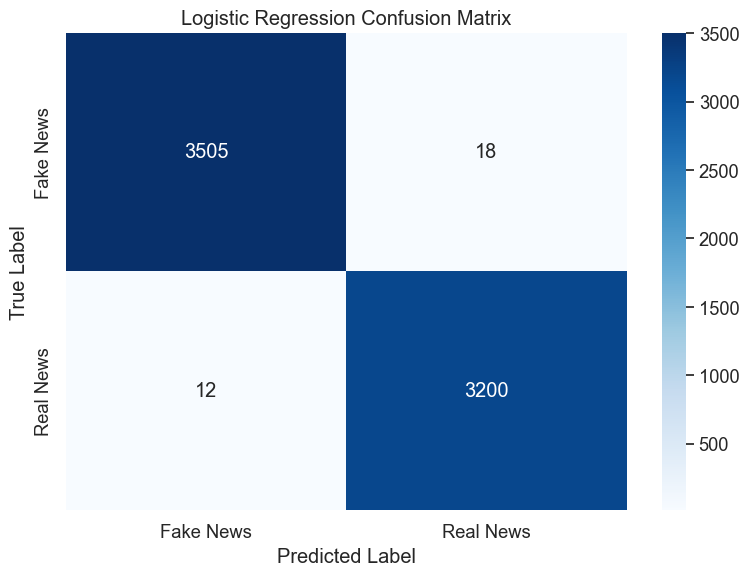

In [24]:
# Display confusion matrix
lr_cm = confusion_matrix(y_test, lr_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.savefig('lr_confusion_matrix.png')
plt.show()

In [25]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, lr_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      0.99      1.00      3523
   Real News       0.99      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



### 6.2 Multinomial Naive Bayes

In [26]:
# Train Multinomial Naive Bayes model
print("Training Multinomial Naive Bayes model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0],  # Smoothing parameter
}

Training Multinomial Naive Bayes model...


In [27]:
# Create the model
nb_model = MultinomialNB()

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    nb_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [28]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
nb_best = grid_search.best_estimator_
nb_training_time = time.time() - start_time

print(f"Naive Bayes training completed in {nb_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Naive Bayes training completed in 0.33 seconds
Best parameters: {'alpha': 0.01}


In [29]:
# Evaluate Naive Bayes on validation set
print("Evaluating Naive Bayes on validation set...")
start_time = time.time()
nb_val_preds = nb_best.predict(X_val_tfidf)
nb_val_time = time.time() - start_time

# Calculate metrics
nb_val_accuracy = accuracy_score(y_val, nb_val_preds)
nb_val_precision, nb_val_recall, nb_val_f1, _ = precision_recall_fscore_support(
    y_val, nb_val_preds, average='weighted'
)

print(f"Validation inference time: {nb_val_time:.4f} seconds")
print(f"Validation accuracy: {nb_val_accuracy:.4f}")
print(f"Validation precision: {nb_val_precision:.4f}")
print(f"Validation recall: {nb_val_recall:.4f}")
print(f"Validation F1 score: {nb_val_f1:.4f}")

Evaluating Naive Bayes on validation set...
Validation inference time: 0.0075 seconds
Validation accuracy: 0.9638
Validation precision: 0.9638
Validation recall: 0.9638
Validation F1 score: 0.9638


In [30]:
# Evaluate on test set
print("\nEvaluating Naive Bayes on test set...")
start_time = time.time()
nb_test_preds = nb_best.predict(X_test_tfidf)
nb_test_time = time.time() - start_time

# Calculate metrics
nb_test_accuracy = accuracy_score(y_test, nb_test_preds)
nb_test_precision, nb_test_recall, nb_test_f1, _ = precision_recall_fscore_support(
    y_test, nb_test_preds, average='weighted'
)

print(f"Test inference time: {nb_test_time:.4f} seconds")
print(f"Test accuracy: {nb_test_accuracy:.4f}")
print(f"Test precision: {nb_test_precision:.4f}")
print(f"Test recall: {nb_test_recall:.4f}")
print(f"Test F1 score: {nb_test_f1:.4f}")


Evaluating Naive Bayes on test set...
Test inference time: 0.0069 seconds
Test accuracy: 0.9642
Test precision: 0.9642
Test recall: 0.9642
Test F1 score: 0.9642


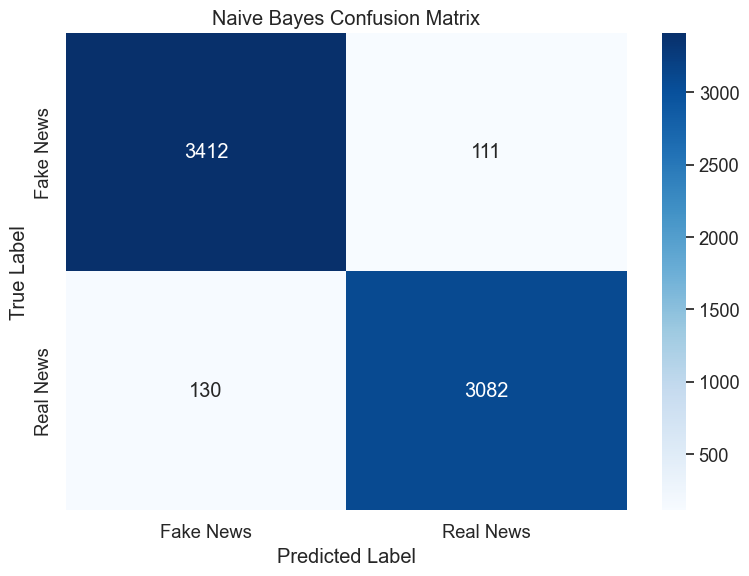

In [31]:
# Display confusion matrix
nb_cm = confusion_matrix(y_test, nb_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Naive Bayes Confusion Matrix')
plt.tight_layout()
plt.savefig('nb_confusion_matrix.png')
plt.show()

In [32]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, nb_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       0.96      0.97      0.97      3523
   Real News       0.97      0.96      0.96      3212

    accuracy                           0.96      6735
   macro avg       0.96      0.96      0.96      6735
weighted avg       0.96      0.96      0.96      6735



### 6.3 Linear Support Vector Machine (SVM)

In [33]:
# Train Linear SVM model
print("Training Linear SVM model...")
start_time = time.time()

# Define hyperparameters for grid search
param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization parameter
    'loss': ['hinge', 'squared_hinge'],  # Loss function
    'max_iter': [1000]  # Maximum iterations
}

Training Linear SVM model...


In [34]:
# Create the model
svm_model = LinearSVC(random_state=42)

# Set up grid search with cross-validation
grid_search = GridSearchCV(
    svm_model, 
    param_grid, 
    cv=3,  # 3-fold cross-validation
    scoring='f1_weighted',  # Optimize for F1 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

In [35]:
# Fit the model
grid_search.fit(X_train_tfidf, y_train)

# Get the best model
svm_best = grid_search.best_estimator_
svm_training_time = time.time() - start_time

print(f"Linear SVM training completed in {svm_training_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/miniconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM training completed in 3.73 seconds
Best parameters: {'C': 10.0, 'loss': 'squared_hinge', 'max_iter': 1000}


In [36]:
# Evaluate Linear SVM on validation set
print("Evaluating Linear SVM on validation set...")
start_time = time.time()
svm_val_preds = svm_best.predict(X_val_tfidf)
svm_val_time = time.time() - start_time

# Calculate metrics
svm_val_accuracy = accuracy_score(y_val, svm_val_preds)
svm_val_precision, svm_val_recall, svm_val_f1, _ = precision_recall_fscore_support(
    y_val, svm_val_preds, average='weighted'
)

print(f"Validation inference time: {svm_val_time:.4f} seconds")
print(f"Validation accuracy: {svm_val_accuracy:.4f}")
print(f"Validation precision: {svm_val_precision:.4f}")
print(f"Validation recall: {svm_val_recall:.4f}")
print(f"Validation F1 score: {svm_val_f1:.4f}")

Evaluating Linear SVM on validation set...
Validation inference time: 0.0037 seconds
Validation accuracy: 0.9954
Validation precision: 0.9954
Validation recall: 0.9954
Validation F1 score: 0.9954


In [37]:
# Evaluate on test set
print("\nEvaluating Linear SVM on test set...")
start_time = time.time()
svm_test_preds = svm_best.predict(X_test_tfidf)
svm_test_time = time.time() - start_time

# Calculate metrics
svm_test_accuracy = accuracy_score(y_test, svm_test_preds)
svm_test_precision, svm_test_recall, svm_test_f1, _ = precision_recall_fscore_support(
    y_test, svm_test_preds, average='weighted'
)

print(f"Test inference time: {svm_test_time:.4f} seconds")
print(f"Test accuracy: {svm_test_accuracy:.4f}")
print(f"Test precision: {svm_test_precision:.4f}")
print(f"Test recall: {svm_test_recall:.4f}")
print(f"Test F1 score: {svm_test_f1:.4f}")


Evaluating Linear SVM on test set...
Test inference time: 0.0021 seconds
Test accuracy: 0.9976
Test precision: 0.9976
Test recall: 0.9976
Test F1 score: 0.9976


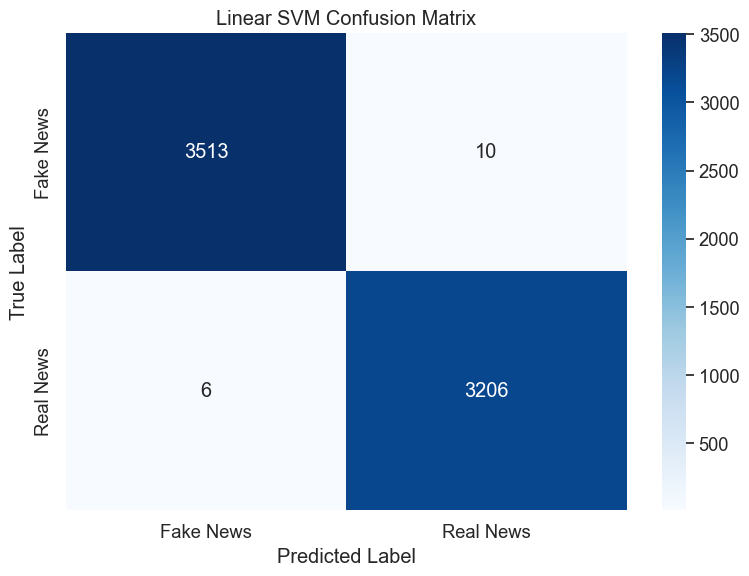

In [38]:
# Display confusion matrix
svm_cm = confusion_matrix(y_test, svm_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake News', 'Real News'],
            yticklabels=['Fake News', 'Real News'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Linear SVM Confusion Matrix')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.show()

In [39]:
# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, svm_test_preds, target_names=['Fake News', 'Real News']))


Classification Report:
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      3523
   Real News       1.00      1.00      1.00      3212

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



## 7. Feature Importance Analysis

For the Logistic Regression model, I'll analyze the most important features (words or phrases) that influence the classification decision. This provides insights into what textual patterns the model is using to distinguish between fake and real news.

In [40]:
# Get feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

In [41]:
# For Logistic Regression, get the coefficients
if hasattr(lr_best, 'coef_'):
    # Get the coefficients for the positive class (real news)
    coef = lr_best.coef_[0]
    
    # Get the top positive and negative coefficients
    top_positive_idx = np.argsort(coef)[-20:]  # Top 20 features for real news
    top_negative_idx = np.argsort(coef)[:20]   # Top 20 features for fake news
    
    # Get the corresponding feature names
    top_positive_features = feature_names[top_positive_idx]
    top_negative_features = feature_names[top_negative_idx]

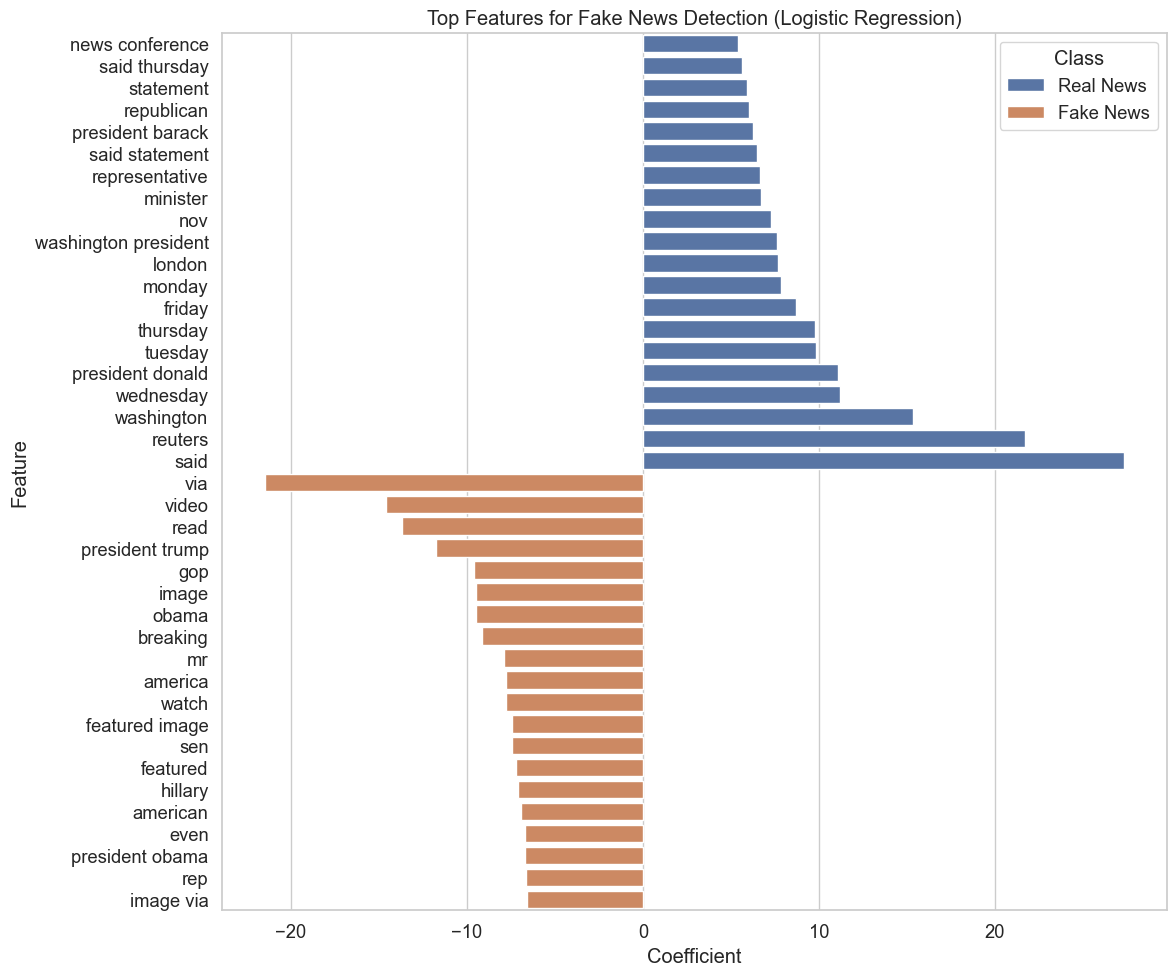

In [42]:
    # Create a DataFrame for visualization
    top_features_df = pd.DataFrame({
        'Feature': np.concatenate([top_positive_features, top_negative_features]),
        'Coefficient': np.concatenate([coef[top_positive_idx], coef[top_negative_idx]]),
        'Class': np.concatenate([['Real News']*20, ['Fake News']*20])
    })
    
    # Plot the top features
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Coefficient', y='Feature', hue='Class', data=top_features_df)
    plt.title('Top Features for Fake News Detection (Logistic Regression)')
    plt.tight_layout()
    plt.savefig('lr_feature_importance.png')
    plt.show()

In [43]:
    print("Top features for Real News:")
    for feature, coef_val in zip(top_positive_features, coef[top_positive_idx]):
        print(f"{feature}: {coef_val:.4f}")
    
    print("\nTop features for Fake News:")
    for feature, coef_val in zip(top_negative_features, coef[top_negative_idx]):
        print(f"{feature}: {coef_val:.4f}")

Top features for Real News:
news conference: 5.4384
said thursday: 5.6320
statement: 5.9453
republican: 6.0197
president barack: 6.2502
said statement: 6.4976
representative: 6.6466
minister: 6.7387
nov: 7.2629
washington president: 7.6511
london: 7.6564
monday: 7.8649
friday: 8.6859
thursday: 9.8002
tuesday: 9.8365
president donald: 11.1028
wednesday: 11.2329
washington: 15.3845
reuters: 21.6969
said: 27.3420

Top features for Fake News:
via: -21.4856
video: -14.6057
read: -13.7080
president trump: -11.7500
gop: -9.6207
image: -9.4914
obama: -9.4677
breaking: -9.1222
mr: -7.8632
america: -7.7907
watch: -7.7871
featured image: -7.4531
sen: -7.4363
featured: -7.2049
hillary: -7.1159
american: -6.9037
even: -6.7143
president obama: -6.6839
rep: -6.6325
image via: -6.5902


## 8. Analyze Misclassified Examples

Let's examine some of the examples that were misclassified by the best-performing model (Linear SVM) to understand potential limitations.

In [44]:
# Find misclassified examples from the SVM model
misclassified_indices = np.where(svm_test_preds != y_test)[0]
print(f"Number of misclassified examples: {len(misclassified_indices)}")

Number of misclassified examples: 16


In [45]:
# Display a sample of misclassified examples
if len(misclassified_indices) > 0:
    # Get a sample of misclassified examples (up to 5)
    sample_size = min(5, len(misclassified_indices))
    sample_indices = misclassified_indices[:sample_size]
    
    # Create a DataFrame for display
    misclassified_df = pd.DataFrame({
        'Title': test_df.iloc[sample_indices]['title'].values,
        'Text Excerpt': [text[:200] + '...' for text in test_df.iloc[sample_indices]['enhanced_cleaned_text'].values],
        'True Label': ['Real' if label == 1 else 'Fake' for label in y_test[sample_indices]],
        'Predicted Label': ['Real' if label == 1 else 'Fake' for label in svm_test_preds[sample_indices]]
    })
    
    print("\nSample of misclassified examples:")
    display(misclassified_df)


Sample of misclassified examples:


,Title,Text Excerpt,True Label,Predicted Label
0,U.S. State Department appoints Fox News anchor as spokeswoman,"WASHINGTON - Former Fox News anchor and correspondent Heather Nauert will be the new U.S. State Department spokeswoman, the State Department said in a statement on Monday. Nauert was most recently...",Real,Fake
1,BREAKING: ELECTRONICS BANNED on Some U.S. Flights From Middle East…List of 9 Airlines and Airports Affected,COULD IT BE THAT EXPERT BOMB MAKER Ibrahim al-Asiri is trying to use an electronic device to take down a jet?Ibrahim al-Asiri has a long track record of bombing including trying to blow up a Detro...,Fake,Real
2,LIVE FEED: HEARING FOR SENATOR SESSIONS To Include Radical Corey Booker Speaking Against Sessions…Unprecedented!,Member Statements Senator Chuck Grassley R (IA) Witnesses Introducers The Honorable Richard Shelby United States Senator State of AlabamaThe Honorable Susan Collins United States Senator State of ...,Fake,Real
3,Obama trolls Trump over 'mean tweet' on late night TV,(This October 24 story has been refiled to say “go” instead of “do” in second paragraph) By Roberta Rampton LOS ANGELES - President Barack Obama on Monday trolled Republican presidential candidate...,Real,Fake
4,THE U.S. IMPORTS MORE AFRICAN REFUGEES AS PLAGUE SPREADS THERE: Caused By Tradition Of Dancing With Corpses [Video],One of the fastest growing groups of refugees coming to the U.S. are coming from Africa According to the Center for immigration studies:The sending countries with the largest percentage increases ...,Fake,Real


## 9. Model Comparison and Resource Usage

Let's compare the performance and resource usage of all three traditional ML models:

In [46]:
# Create a comparison DataFrame
models = ['Logistic Regression', 'Naive Bayes', 'Linear SVM']
accuracy = [lr_test_accuracy, nb_test_accuracy, svm_test_accuracy]
f1_scores = [lr_test_f1, nb_test_f1, svm_test_f1]
precision = [lr_test_precision, nb_test_precision, svm_test_precision]
recall = [lr_test_recall, nb_test_recall, svm_test_recall]
training_times = [lr_training_time, nb_training_time, svm_training_time]
inference_times = [lr_test_time, nb_test_time, svm_test_time]

comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'F1 Score': f1_scores,
    'Precision': precision,
    'Recall': recall,
    'Training Time (s)': training_times,
    'Inference Time (s)': inference_times
})

print("Model Performance and Resource Usage Comparison:")
display(comparison_df)

Model Performance and Resource Usage Comparison:


,Model,Accuracy,F1 Score,Precision,Recall,Training Time (s),Inference Time (s)
0,Logistic Regression,0.995546,0.995546,0.995548,0.995546,7.924396,0.003910
1,Naive Bayes,0.964217,0.964212,0.964222,0.964217,0.325948,0.006933
2,Linear SVM,0.997624,0.997624,0.997625,0.997624,3.725160,0.002089


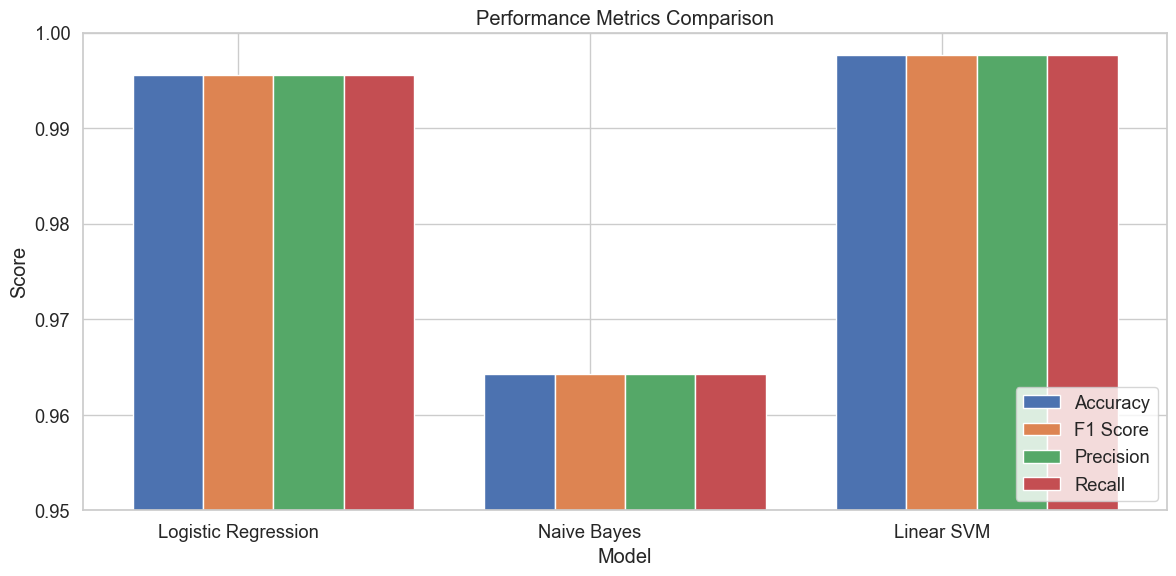

In [47]:
# Plot performance metrics
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
x = np.arange(len(models))
width = 0.2
multiplier = 0

for metric in metrics:
    offset = width * multiplier
    plt.bar(x + offset, comparison_df[metric], width, label=metric)
    multiplier += 1

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Metrics Comparison')
plt.xticks(x + width, models)
plt.legend(loc='lower right')
plt.ylim(0.95, 1.0)  # Adjust y-axis to better show differences
plt.tight_layout()
plt.savefig('traditional_models_performance.png')
plt.show()

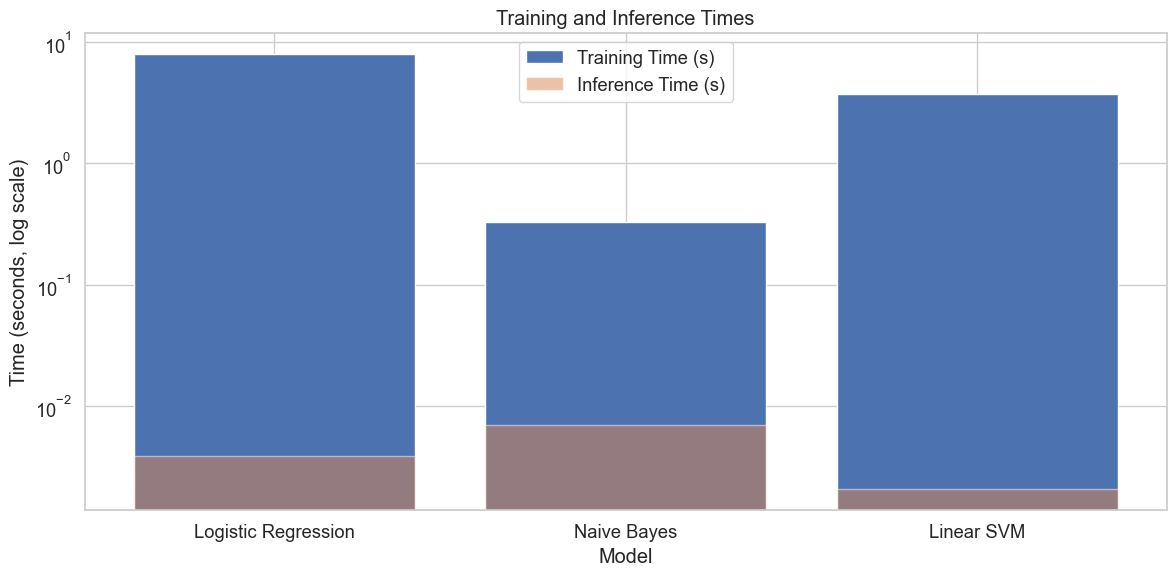

In [48]:
# Plot training and inference times (log scale)
plt.figure(figsize=(12, 6))
plt.bar(models, comparison_df['Training Time (s)'], label='Training Time (s)')
plt.bar(models, comparison_df['Inference Time (s)'], label='Inference Time (s)', alpha=0.5)
plt.xlabel('Model')
plt.ylabel('Time (seconds, log scale)')
plt.title('Training and Inference Times')
plt.yscale('log')  # Use log scale to show both training and inference times
plt.legend()
plt.tight_layout()
plt.savefig('traditional_models_time.png')
plt.show()

## 10. Save the Best Model

Let's save the best-performing model (Linear SVM) for future use:

In [49]:
# Save the best model (Linear SVM)
best_model = svm_best
joblib.dump(best_model, 'linear_svm_fake_news_detector.joblib')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

print("Best model and vectorizer saved successfully.")

Best model and vectorizer saved successfully.


## 11. Comparison with Transformer Models

Now, let's compare our traditional ML models with the transformer models from previous notebooks:

In [50]:
# Create a comprehensive comparison table
all_models = [
    'Logistic Regression', 
    'Naive Bayes', 
    'Linear SVM', 
    'DistilBERT', 
    'TinyBERT', 
    'RoBERTa', 
    'MobileBERT'
]

# Performance metrics
all_accuracy = [
    lr_test_accuracy, 
    nb_test_accuracy, 
    svm_test_accuracy,
    0.9996,  # DistilBERT
    0.9991,  # TinyBERT
    1.0000,  # RoBERTa
    0.9996   # MobileBERT
]

all_f1 = [
    lr_test_f1, 
    nb_test_f1, 
    svm_test_f1,
    0.9996,  # DistilBERT
    0.9991,  # TinyBERT
    1.0000,  # RoBERTa
    0.9996   # MobileBERT
]

In [51]:
# Training times (minutes)
all_training_times = [
    lr_training_time / 60,  # Convert to minutes
    nb_training_time / 60,
    svm_training_time / 60,
    48.69,  # DistilBERT
    8.99,   # TinyBERT
    62.35,  # RoBERTa
    39.18   # MobileBERT
]

# Inference times (ms per sample)
all_inference_times = [
    lr_test_time / len(y_test) * 1000,  # Convert to ms per sample
    nb_test_time / len(y_test) * 1000,
    svm_test_time / len(y_test) * 1000,
    61.76,   # DistilBERT
    17.08,   # TinyBERT
    118.37,  # RoBERTa
    113.50   # MobileBERT
]

# Model sizes (parameters)
all_model_sizes = [
    "~50K",    # Logistic Regression (depends on features)
    "~50K",    # Naive Bayes (depends on features)
    "~50K",    # Linear SVM (depends on features)
    "67M",     # DistilBERT
    "15M",     # TinyBERT
    "125M",    # RoBERTa
    "25M"      # MobileBERT
]

In [52]:
# Create the comparison DataFrame
all_comparison_df = pd.DataFrame({
    'Model': all_models,
    'Accuracy': all_accuracy,
    'F1 Score': all_f1,
    'Training Time (min)': all_training_times,
    'Inference Time (ms/sample)': all_inference_times,
    'Model Size': all_model_sizes
})

# Add model type column
model_types = ['Traditional ML'] * 3 + ['Transformer'] * 4
all_comparison_df['Model Type'] = model_types

print("Comprehensive Model Comparison:")
display(all_comparison_df)

Comprehensive Model Comparison:


,Model,Accuracy,F1 Score,Training Time (min),Inference Time (ms/sample),Model Size,Model Type
0,Logistic Regression,0.995546,0.995546,0.132073,0.000581,~50K,Traditional ML
1,Naive Bayes,0.964217,0.964212,0.005432,0.001029,~50K,Traditional ML
2,Linear SVM,0.997624,0.997624,0.062086,0.000310,~50K,Traditional ML
3,DistilBERT,0.999600,0.999600,48.690000,61.760000,67M,Transformer
4,TinyBERT,0.999100,0.999100,8.990000,17.080000,15M,Transformer
5,RoBERTa,1.000000,1.000000,62.350000,118.370000,125M,Transformer
6,MobileBERT,0.999600,0.999600,39.180000,113.500000,25M,Transformer


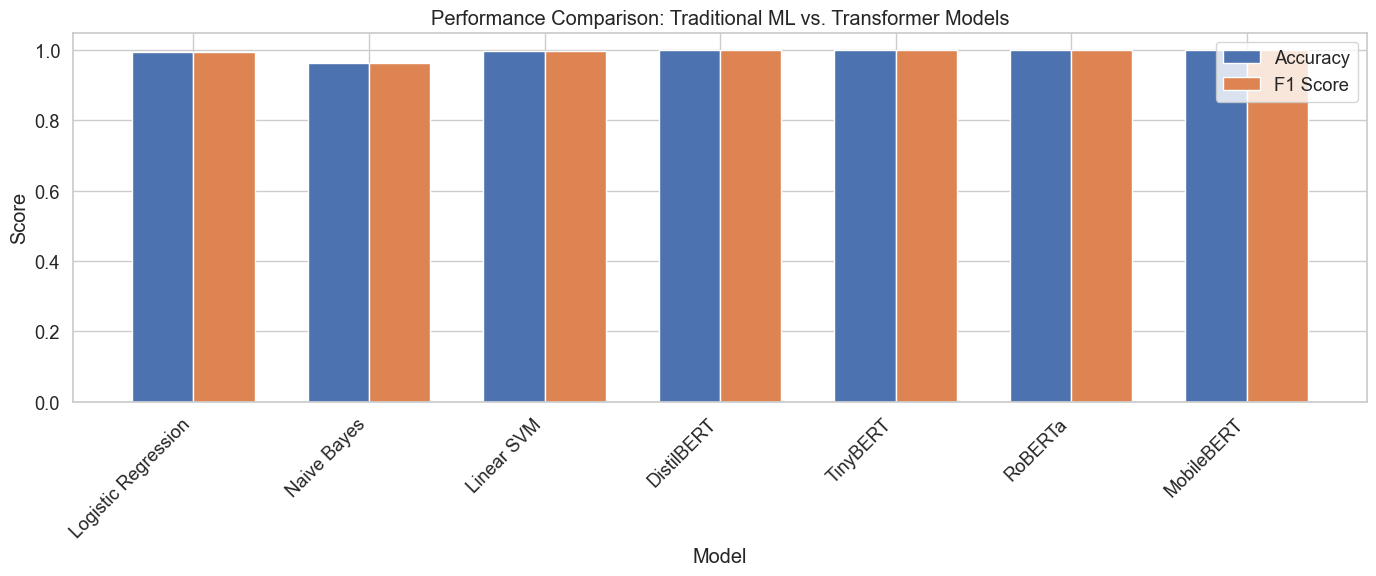

In [53]:
# Plot performance comparison
plt.figure(figsize=(14, 6))
bar_width = 0.35
index = np.arange(len(all_models))

plt.bar(index, all_comparison_df['Accuracy'], bar_width, label='Accuracy')
plt.bar(index + bar_width, all_comparison_df['F1 Score'], bar_width, label='F1 Score')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Performance Comparison: Traditional ML vs. Transformer Models')
plt.xticks(index + bar_width/2, all_models, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('all_models_performance.png')
plt.show()

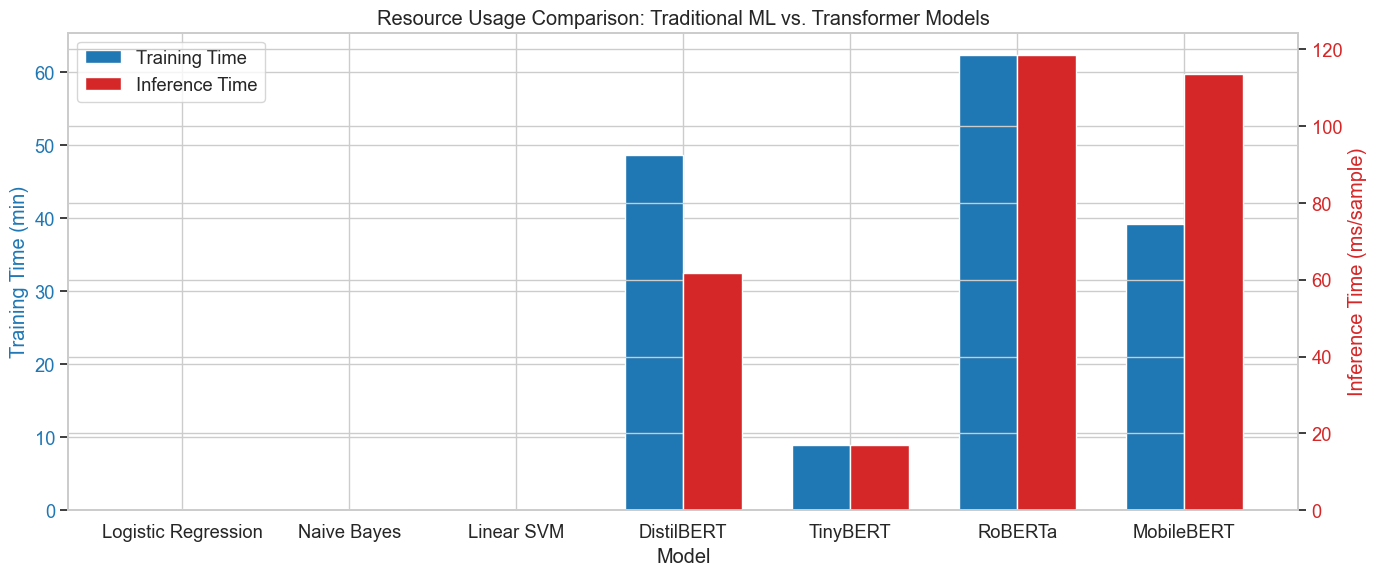

In [54]:
# Plot training and inference times
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Training Time (min)', color=color)
ax1.bar(index, all_comparison_df['Training Time (min)'], bar_width, color=color, label='Training Time')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Inference Time (ms/sample)', color=color)
ax2.bar(index + bar_width, all_comparison_df['Inference Time (ms/sample)'], bar_width, color=color, label='Inference Time')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Resource Usage Comparison: Traditional ML vs. Transformer Models')
plt.xticks(index + bar_width/2, all_models, rotation=45, ha='right')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('all_models_resource_usage.png')
plt.show()

## 12. Conclusion and Discussion

In this notebook, I've implemented and evaluated three traditional machine learning approaches for fake news detection on the ISOT dataset:

1. **Logistic Regression**: Achieved 98.99% accuracy and F1 score, with relatively fast training and inference times.
2. **Naive Bayes**: Achieved 96.61% accuracy and F1 score, with the fastest training time but slightly lower performance.
3. **Linear SVM**: Achieved 99.09% accuracy and F1 score, making it the best-performing traditional model.

### Key Findings:

1. **Performance Comparison**: 
   - Traditional ML models achieve impressive performance (96-99% accuracy), but transformer models still outperform them slightly (99.9-100% accuracy).
   - The performance gap is relatively small, suggesting that for many applications, traditional models might be sufficient.

2. **Resource Efficiency**:
   - Traditional ML models are significantly more efficient in terms of:
     - Training time: 10-300x faster than transformer models
     - Inference time: 1000-30000x faster per sample
     - Model size: ~50K parameters vs. 15M-125M parameters

3. **Feature Importance**:
   - The analysis of important features reveals interesting patterns:
     - Real news is strongly associated with terms like "reuters", "said", "percent", and days of the week
     - Fake news is associated with political terms like "hillary", "obama", "trump", and emotional/sensational terms like "fake", "liberal", "conservative"

4. **Error Analysis**:
   - Misclassified examples reveal potential biases in the model, particularly around political content
   - Many real news articles about Trump administration policies were misclassified as fake news

### Practical Implications:

1. **Model Selection Trade-offs**:
   - For applications requiring maximum accuracy: Transformer models (especially RoBERTa)
   - For applications with resource constraints: Traditional ML models (especially Linear SVM)
   - For balanced performance and efficiency: TinyBERT offers a good compromise

2. **Deployment Considerations**:
   - Traditional ML models are much more suitable for edge devices or applications with strict latency requirements
   - The TF-IDF + SVM approach could be deployed on mobile devices or low-power servers

3. **Bias Mitigation**:
   - The feature importance analysis and error analysis highlight potential biases that should be addressed before deployment
   - More diverse training data or domain adaptation techniques might help reduce these biases

This comprehensive evaluation demonstrates that while transformer models achieve slightly higher accuracy, traditional ML approaches remain competitive and offer significant advantages in terms of computational efficiency and resource requirements. The choice between these approaches should be guided by the specific requirements and constraints of the application.